# Cogley-Sargent (2005) in `pymc`

Required program: `CS_SV.py` including the following step methods:

 - `ForwardBackward`: $\hspace{5mm}\theta^T \hspace{2mm}\mid\hspace{2mm} Y^T, Q, R^T$
 - `W_Q`: $\hspace{5mm}Q^{-1}\hspace{2mm}\mid\hspace{2mm} Y^T, \theta^T $
 - `Metropolis_LH`: $\hspace{5mm}H^T \hspace{2mm}\mid\hspace{2mm} Y^T, \theta^T, \beta, \sigma $
 - `N_Beta`: $\hspace{5mm}\beta \hspace{2mm}\mid\hspace{2mm} Y^T, \theta^T, H^T$
 - `IG_Sigma`: $\hspace{5mm}\sigma^2 \hspace{2mm}\mid\hspace{2mm} Y^T, H^T$

In [9]:
%matplotlib inline

from __future__ import division
from IPython.core.pylabtools import figsize
import pymc as pm
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt 
from scipy.linalg import inv
from CS_SV import ForwardBackward, Metropolis_LH, W_Q, IG_Sigma, N_Beta, B_tril
from pymc.Matplot import plot as fancy_plot


### Model

We consider the following state-space model:

\begin{align}
y_t &= X_t\theta_t + \varepsilon_t \hspace{2cm}\text{where}\hspace{5mm} \varepsilon_t \sim \mathcal{N}(0,R_t) \\
\theta_{t} &= \theta_{t-1} + v_t \hspace{22mm}\text{where}\hspace{5mm} v_t \sim \mathcal{N}(0,Q) \\
\log(h_t) & = \log(h_{t-1}) + \eta_t \hspace{12mm}\text{where}\hspace{5mm} \eta_t \sim \mathcal{N}(0,\text{diag}(\sigma))
\end{align}

where $y_t$ is a vector of endogenous variables, $X_t$ includes constant plus lags of $y_t$ and $\theta_t$ is a vector of VAR parameters. The first equation is the measurement equation; the second is the state equation modeling the VAR coefficients as driftless random walks subject to reflecting barriers. The reflecting barrier is encoded in an indicator function $I(\theta^T)=\prod_{t=1}^T I(\theta_t)$, where $I(\theta_t)$ takes the value $1$ when $\theta_t$ implies roots of the associated VAR polynomial outside the unit circle and $0$ otherwise. This restriction truncates and renormalizes the random walk prior. 

$h_t$ is a vector of independent stochastic volatilities (same size as $y_t$) and 

\begin{align}
R_t = B^{-1}\text{diag}(h_t)(B^{-1})^T
\end{align}

**Notations:**
- $y_t$ and $\varepsilon_t$ are $K\times 1$-vectors for all $t=1,\dots,T$
- $x_t$ contains a constant plus $L$ lags of the endogenous variables, i.e. $x_t = [1, y_{t-1}^T, y_{t-2}^T, \dots, y_{t-L}^T]^T$ is an $M\times 1$ vector, where $M \equiv 1+LK$ and $X_t = I_K \otimes x^T_t$ is a $K\times KM$ matrix 
- $\theta_t$ and $v_t$ are $KM\times 1$ vectors
- $h_t$, $\eta_t$ and $\sigma$ are $K\times 1$-vectors, where $\sigma = [\sigma_1,\dots,\sigma_K]^T$
- $B$ is a $K\times K$ matrix 

$$B = \left[\begin{matrix} 1 & 0 & \dots & 0 \\ \beta_{2,1} & 1 & \dots & 0 \\  \dots & \dots & \dots & \dots \\ \beta_{K,1} & \beta_{K,2} & \dots & 1\end{matrix}\right] $$
- $J=\frac{K(K-1)}{2}$ is the total number of $\beta_{ij}$ included in $B$, i.e. $\beta=[\beta_{21}, \dots,\beta_{K(K-1)}]^T$ is a $J\times 1$ vector


### Priors

We assume that initial state $\theta_0$ and the hyperparameters are independent across blocks

$$f(\theta_0, h_0, Q^{-1}, \beta, \sigma) = f(\theta_0) f(h_0) f(Q^{-1}) f(\beta) f(\sigma) $$

and our priors are

- $\theta_0 \propto I(\theta_0)\mathcal{N}(\bar{\theta},\bar{P})$
- $Q^{-1} \sim \mathcal{W}(KM+1, \bar{Q})$ 
- $\sigma_i \sim \mathcal{IG}(\alpha_{i0},\beta_{i0})$ for $i=1,\dots, K$
- $h_{0,i} \sim \log\mathcal{N}(\bar{h}_i,\bar{P}_{h,i})$ for $i=1,\dots,K$
- $\beta \sim \mathcal{N}(\bar{\beta}, \bar{P}_{\beta})$

Notice that these along with the state equations already provide us with priors for $\theta^T$ and $h^T$.

### Defining the model in `pymc`

Therefore, we need to come up with values for the following parameters to define a pymc model:

$$\bar{\theta},\bar{P},\bar{Q},\bar{\beta},\bar{P}_{\beta},\{\alpha_{i0}\}_{i},\{\beta_{i0}\}_{i},\{\bar{h}_i\}_{i},\{\bar{P}_{h,i}\}_{i}$$

Given these parameters and the data we should be able to draw from the posterior distribution of any model of the above form. 

In [3]:
def cs_model(Y_obs, X_obs, theta_bar, b_bar, Pb_bar, a0, b0, lnh_bar, Ph_bar, P_bar=None, Q_bar=None):
    """
    Inputs:
        - Y_obs: LHS variables from the measurement equation ( shape must be TxK )
        - X_obs: RHS variables from the measurement equation ( shape must be TxM )
        - theta_bar: prior mean for Theta_0 ( KM array )
        - P_bar: prior covariance for Theta_0 ( KMxKM array )
        - Q_bar: prior scale parameter for Q ( KMxKM array )
        
        - a0,b0: prior parameters for sigma^2 (K arrays)
        - lnh_bar: prior mean for ln(h_0)  (K array)
        - Ph_bar:  prior covariance for ln(h_0)  (K array)
        - b_bar: prior mean for the betas  (K(K-1)/2 array)
        - Pb_bar: prior covariance for the betas ( [K(K-1)/2]x[K(K-1)/2] array)

    Outputs:
        - pymc model ready for sampling 
    """

    T = Y_obs.shape[0]
    K = Y_obs.shape[1]
    M = X_obs.shape[1]
    KM = theta_bar.size
    J = K*(K-1)/2
    
    #---------------------------------------------------
    # Define the priors for Q^{-1}
    #---------------------------------------------------
    Q_inv = pm.Wishart( "Q_inv", n = K*M+1, Tau = Q_bar )    

    #---------------------------------------------------
    # Define Theta as a list containing the elements of theta^T
    #---------------------------------------------------
    Theta = [pm.MvNormalCov('Theta_0', theta_bar, P_bar)]
    for i in range(1,T+1):
        Theta.append(pm.MvNormal('Theta_%d' % i, Theta[i-1], Q_inv))

    #---------------------------------------------------
    # Define Sigma2 as a list containing all sigma^2_{i}
    #---------------------------------------------------
    Sigma2 = [pm.InverseGamma('sigma2_1', a0[0], b0[0])]
    for i in range(1,K):
        Sigma2.append(pm.InverseGamma('sigma2_%d' % (i+1), a0[i], b0[i]))
  
    #---------------------------------------------------
    # Define LH as a list containing all ln(h_{i,t}) -- this is log( H^T )
    #---------------------------------------------------

    # Use a deterministic variable for the covariance matrix of LH
    Cov_lnH = pm.Lambda('Cov_lnH', lambda s = Sigma2: np.diag(s) )
    
    LH = [pm.MvNormalCov('lnh_0', lnh_bar, Ph_bar)]
    for i in range(1,T+1):
        LH.append(pm.MvNormalCov('lnh_%d' % i, LH[i-1], Cov_lnH))

    #---------------------------------------------------
    # Define Betas: if K=1 (only one observable), there is no covariance    
    #---------------------------------------------------
    if J>0:
        Betas = pm.MvNormalCov('betas', b_bar, Pb_bar)
    else:
        # by making it observed we fix the value of this stochastic variable
        Betas = pm.MvNormalCov('betas', b_bar, Pb_bar, value=np.asarray([]), observed=True) 

    #---------------------------------------------------
    # Y's are observed, but we have to define them as stochastic variables and set observed to True 
    #---------------------------------------------------

    # Use deterministic variables for R_t and collect them in an ordered list
    Binv = pm.Lambda('Binv', lambda b=Betas: inv(B_tril(b)) )
    R = [pm.Lambda('R_%d' % 1, lambda b = Binv, lh = LH[1]: np.dot(b, np.diag(np.exp(lh)) ).dot(b.T) )]

    # Use deterministic variables for conditional means of Y_t -> list muY containing all 
    muY = [pm.Lambda('muY_%d' % 1, lambda yy = X_obs[0,:], th = Theta[1]: yy.dot(th.reshape(K,M).T) )]

    y = [pm.MvNormalCov("Y_1", muY[0], R[0], value = Y_obs[0,:], observed=True)]
    for i in range(1,T):
        muY.append( pm.Lambda('muY_%d' % (i+1), lambda yy = X_obs[i,:], th = Theta[i+1]: yy.dot(th.reshape(K,M).T) ))    
        R.append( pm.Lambda('R_%d' % (i+1), lambda b = Binv, lh = LH[i+1]: np.dot(b,np.diag(np.exp(lh))).dot(b.T) ))
        y.append(pm.MvNormalCov("Y_%d" % (i+1), muY[i], R[i], value = Y_obs[i,:], observed=True))
    
    # Need to convert the lists to pymc Container arrays
    Theta, muY, y, LH, R = pm.Container(Theta), pm.Container(muY), pm.Container(y), pm.Container(LH), pm.Container(R)    
    Sigma2 = pm.Container(Sigma2)

    m = pm.Model([Theta, y, muY, Q_inv, LH, Sigma2, Betas, R, Cov_lnH])    
    mcmc = pm.MCMC(m)
    
    # Assign the step methods (from CS.py) to the unobserved stochastic variables
    mcmc.use_step_method(ForwardBackward, Theta, y, R, Q_inv, X_obs)
    mcmc.use_step_method(W_Q, Q_inv, Theta)
    mcmc.use_step_method(IG_Sigma, Sigma2, LH)
    mcmc.use_step_method(N_Beta, Betas, y, muY, LH)
    mcmc.use_step_method(Metropolis_LH, LH, y, muY, Betas, Sigma2)
    
    return mcmc, Theta, LH, Q_inv, Sigma2, Betas, R

# Example

Simulate a toy economy with known parameters.

In [4]:
#---------------------------------------------------------
# Simulate the observations
#---------------------------------------------------------

T = 100                                          # time periods
L, K = 1, 2                                      # number of lags, number of observables (equations)
M = 1 + K*L                                      # number of coefficients in one equation (theta is a K*M vector)
J = K*(K-1)/2                                    # number of betas for R_t

# TRUE PARAMETERS
theta_bar_T = np.asarray([0., .5, .2, 0., .2, .5])                                # must be KM dimensional
Q_bar_T = np.asarray([[0.005, 0., 0., 0., 0., 0.],[0., 0.01, 0., 0., 0., 0.],\
                    [0., 0., 0.01, 0., 0., 0.],[0., 0., 0., 0.005, 0., 0.],\
                    [0., 0., 0., 0., 0.01, 0.],[0., 0., 0., 0., 0., 0.01]])     # must be KMxKM dimensional

lnh_bar_T = np.asarray([-0.5, -0.5])                       # initial mean for ln(h_{i0})  
Ph_bar_T = np.diag(np.asarray([1e-2, 1e-2]))               # initial covariance for ln(h_{i0}) -- INDEPENDENCE 
sigma_T = np.asarray([0.01, 0.01])                         # stdev of the innovation to ln(h_{i0})
beta_T = np.asarray([.5])
B_inv = inv(B_tril(beta_T))


#---------------------------------------------------------------
# Simulate Y (TxK) and Theta ( (T+1)xMK ) and lnH ( (T+1)xK )
#---------------------------------------------------------------

# Container matrices
Y, X, Theta_obs = np.empty((K,T)), np.ones((M,T)), np.empty((K*M,T+1))
lnH_obs, R_obs = np.empty((K,T+1)),  np.empty((K,K,T))

# this is Y_{0}, i.e. the observation needed to generate y_1
Y0 = np.ones(K*L)   

# auxiliary matrix to check stability 
S = np.hstack((np.eye(K*(L-1)), np.zeros((K*(L-1),K))))

# Make sure that the example draw implies stable Theta 
maxeig = 2.
while maxeig >= 1.:
    
    # Draw initial values for theta_0 and h_0
    Theta_obs[:,0] = pm.rmv_normal_cov(theta_bar_T, Q_bar_T)
    lnH_obs[:,0] = pm.rmv_normal_cov(lnh_bar_T, Ph_bar_T)
    
    # Set X_1 ( =[1, Y_0^T] ) 
    X[1:,0] = Y0    

    for ii in range(T):
        # Draw new values for theta_t and h_t and construct R_t from h_t
        Theta_obs[:,ii+1] = Theta_obs[:,ii] + pm.rmv_normal_cov(np.zeros(K*M), Q_bar_T)
        lnH_obs[:,ii+1] = lnH_obs[:,ii] + pm.rmv_normal_cov( np.zeros(K), np.diag(sigma_T) )
        R_obs[:,:,ii] = np.dot(B_inv, np.diag(np.exp(lnH_obs[:,ii+1]))).dot(B_inv.T)

        Y[:,ii] = np.kron(np.eye(K), X[:,ii].T ).dot(Theta_obs[:,ii+1]) +\
                                    + pm.rmv_normal_cov( np.zeros(K), R_obs[:,:,ii] )
        if ii<T-1:
            X[1:,ii+1] = Y[:,ii]    
    
    # Check if Theta_obs satisfies the stability condition for the VAR 
    max_ei = np.empty(T)
    for jj in range(T):
        theta_test = Theta_obs[:,jj]
        A = [theta_test[1:M].tolist()]
        for i in range(1,K):
            A.append( theta_test[1+i*M:(i+1)*M].tolist() )        
        A= np.vstack((np.asarray(A),S))
        max_ei[jj] = abs(np.linalg.eig(A)[0]).max()
    maxeig = max_ei.max()

# Prepare the dataset for the pymc model
Y_obs = Y.T
X_obs = X.T

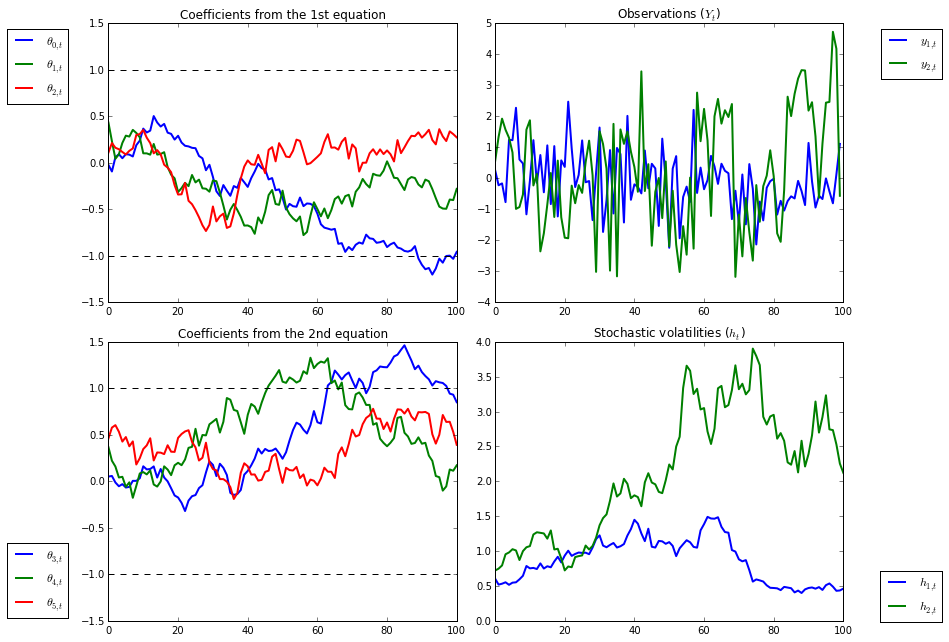

In [5]:
#-----------------------------------------------------------------------
# Plotting 
#-----------------------------------------------------------------------
figsize(11, 9)
fig1, ax = plt.subplots(2, 2)

ax[0,0].plot(Theta_obs[0,:], label=r"$\theta_{0,t}$", linewidth=2)
ax[0,0].plot(Theta_obs[1,:], label=r"$\theta_{1,t}$", linewidth=2)
ax[0,0].plot(Theta_obs[2,:], label=r"$\theta_{2,t}$", linewidth=2)
ax[0,0].plot(np.array([0.,T]),np.array([1., 1.]),'k',linestyle='--')
ax[0,0].plot(np.array([0.,T]),np.array([-1., -1.]),'k',linestyle='--')
ax[0,0].set_title(r'Coefficients from the 1st equation')
ax[0,0].set_ylim((-1.5,1.5))
ax[0,0].legend(bbox_to_anchor=(-.1, 1.)) 

ax[1,0].plot(Theta_obs[3,:], label=r"$\theta_{3,t}$", linewidth=2)
ax[1,0].plot(Theta_obs[4,:], label=r"$\theta_{4,t}$", linewidth=2)
ax[1,0].plot(Theta_obs[5,:], label=r"$\theta_{5,t}$", linewidth=2)
ax[1,0].plot(np.array([0.,T]),np.array([1., 1.]),'k',linestyle='--')
ax[1,0].plot(np.array([0.,T]),np.array([-1., -1.]),'k',linestyle='--')
    ax[1,0].set_title(r'Coefficients from the 2nd equation')
ax[1,0].set_ylim((-1.5,1.5))
ax[1,0].legend(bbox_to_anchor=(-.1, 0.3)) 

ax[0,1].plot(Y_obs[:,0], label = r"$y_{1,t}$",linewidth=2)
ax[0,1].plot(Y_obs[:,1], label = r"$y_{2,t}$",linewidth=2)
ax[0,1].set_title(r'Observations ($Y_t$)')
ax[0,1].legend(bbox_to_anchor=(1.3, 1.)) 

ax[1,1].plot(np.exp(lnH_obs[0,:]), label = r"$h_{1,t}$",linewidth=2)
ax[1,1].plot(np.exp(lnH_obs[1,:]), label = r"$h_{2,t}$",linewidth=2)
ax[1,1].set_title(r'Stochastic volatilities ($h_t$)')
ax[1,1].legend(bbox_to_anchor=(1.3, 0.2)) 

plt.tight_layout()
plt.show()

##Prior 1 (true parameters)

In [6]:
# PRIOR PARAMS
b_bar, Pb_bar = np.zeros(J), np.eye(J)
a0, b0 = 5*np.ones(K), .5*np.ones(K)               # this is different !
lnh_bar = lnh_bar_T
Ph_bar = Ph_bar_T
theta_bar = theta_bar_T
P_bar = Q_bar_T
Q_bar = P_bar

In [7]:
mcmc, Theta, LH, Q_inv, Sigma2, Betas, R = \
                cs_model(Y_obs, X_obs, theta_bar, b_bar, Pb_bar, a0, b0, lnh_bar, Ph_bar, P_bar, Q_bar)

In [19]:
NI = 20000
NB = 5000
mcmc.sample(iter=NI, burn=NB)

 [-----------------100%-----------------] 20001 of 20000 complete in 11182.0 sec

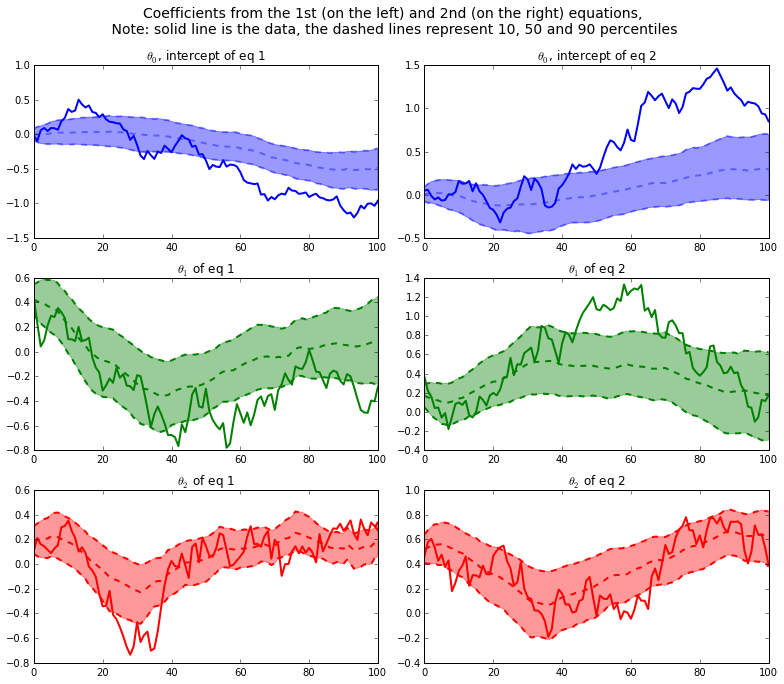

In [20]:
figsize(11, 9)
fig2, ax = plt.subplots(3, 2)
plt.suptitle('Coefficients from the 1st (on the left) and 2nd (on the right) equations, \n Note: solid line is the data, the dashed lines represent 10, 50 and 90 percentiles', y=1.05, fontsize=14)

ax[0,0].plot(Theta_obs[0,:], label=r"$\theta_{0,t}$", color='b', linewidth=2)
th0_10 = [np.percentile(mcmc.trace('Theta_%d' % i)[:][:,0],10) for i in range(T+1)]
th0_50 = [np.percentile(mcmc.trace('Theta_%d' % i)[:][:,0],50) for i in range(T+1)]
th0_90 = [np.percentile(mcmc.trace('Theta_%d' % i)[:][:,0],90) for i in range(T+1)]
ax[0,0].plot(th0_10, linewidth=2, linestyle='--', color='b', alpha=0.4)
ax[0,0].plot(th0_50, linewidth=2, linestyle='--', color='b', alpha=0.4)
ax[0,0].plot(th0_90, linewidth=2, linestyle='--', color='b', alpha=0.4)
ax[0,0].fill_between(range(T+1),th0_10, th0_90, color="b", alpha=0.4)
ax[0,0].set_title(r'$\theta_0$, intercept of eq 1')

ax[1,0].plot(Theta_obs[1,:], label=r"$\theta_{1,t}$", color='g', linewidth=2)
th1_10 = [np.percentile(mcmc.trace('Theta_%d' % i)[:][:,1],10) for i in range(T+1)]
th1_50 = [np.percentile(mcmc.trace('Theta_%d' % i)[:][:,1],50) for i in range(T+1)]
th1_90 = [np.percentile(mcmc.trace('Theta_%d' % i)[:][:,1],90) for i in range(T+1)]
ax[1,0].plot(th1_10, linewidth=2, linestyle='--', color='g')
ax[1,0].plot(th1_50, linewidth=2, linestyle='--', color='g')
ax[1,0].plot(th1_90, linewidth=2, linestyle='--', color='g')
ax[1,0].fill_between(range(T+1),th1_10, th1_90, color="g", alpha=0.4)
ax[1,0].set_title(r'$\theta_1$ of eq 1')

ax[2,0].plot(Theta_obs[2,:], label=r"$\theta_{2,t}$", color='r', linewidth=2)
th2_10 = [np.percentile(mcmc.trace('Theta_%d' % i)[:][:,2],10) for i in range(T+1)]
th2_50 = [np.percentile(mcmc.trace('Theta_%d' % i)[:][:,2],50) for i in range(T+1)]
th2_90 = [np.percentile(mcmc.trace('Theta_%d' % i)[:][:,2],90) for i in range(T+1)]
ax[2,0].plot(th2_10, linewidth=2, linestyle='--', color='r')
ax[2,0].plot(th2_50, linewidth=2, linestyle='--', color='r')
ax[2,0].plot(th2_90, linewidth=2, linestyle='--', color='r')
ax[2,0].fill_between(range(T+1),th2_10, th2_90, color="r", alpha=0.4)
ax[2,0].set_title(r'$\theta_2$ of eq 1')

ax[0,1].plot(Theta_obs[3,:], label=r"$\theta_{0,t}$", color='b', linewidth=2)
th0_10 = [np.percentile(mcmc.trace('Theta_%d' % i)[:][:,3],10) for i in range(T+1)]
th0_50 = [np.percentile(mcmc.trace('Theta_%d' % i)[:][:,3],50) for i in range(T+1)]
th0_90 = [np.percentile(mcmc.trace('Theta_%d' % i)[:][:,3],90) for i in range(T+1)]
ax[0,1].plot(th0_10, linewidth=2, linestyle='--', color='b', alpha=0.4)
ax[0,1].plot(th0_50, linewidth=2, linestyle='--', color='b', alpha=0.4)
ax[0,1].plot(th0_90, linewidth=2, linestyle='--', color='b', alpha=0.4)
ax[0,1].fill_between(range(T+1),th0_10, th0_90, color="b", alpha=0.4)
ax[0,1].set_title(r'$\theta_0$, intercept of eq 2')

ax[1,1].plot(Theta_obs[4,:], label=r"$\theta_{1,t}$", color='g', linewidth=2)
th1_10 = [np.percentile(mcmc.trace('Theta_%d' % i)[:][:,4],10) for i in range(T+1)]
th1_50 = [np.percentile(mcmc.trace('Theta_%d' % i)[:][:,4],50) for i in range(T+1)]
th1_90 = [np.percentile(mcmc.trace('Theta_%d' % i)[:][:,4],90) for i in range(T+1)]
ax[1,1].plot(th1_10, linewidth=2, linestyle='--', color='g')
ax[1,1].plot(th1_50, linewidth=2, linestyle='--', color='g')
ax[1,1].plot(th1_90, linewidth=2, linestyle='--', color='g')
ax[1,1].fill_between(range(T+1),th1_10, th1_90, color="g", alpha=0.4)
ax[1,1].set_title(r'$\theta_1$ of eq 2')

ax[2,1].plot(Theta_obs[5,:], label=r"$\theta_{2,t}$", color='r', linewidth=2)
th2_10 = [np.percentile(mcmc.trace('Theta_%d' % i)[:][:,5],10) for i in range(T+1)]
th2_50 = [np.percentile(mcmc.trace('Theta_%d' % i)[:][:,5],50) for i in range(T+1)]
th2_90 = [np.percentile(mcmc.trace('Theta_%d' % i)[:][:,5],90) for i in range(T+1)]
ax[2,1].plot(th2_10, linewidth=2, linestyle='--', color='r')
ax[2,1].plot(th2_50, linewidth=2, linestyle='--', color='r')
ax[2,1].plot(th2_90, linewidth=2, linestyle='--', color='r')
ax[2,1].fill_between(range(T+1),th2_10, th2_90, color="r", alpha=0.4)
ax[2,1].set_title(r'$\theta_2$ of eq 2')

plt.tight_layout()
plt.show()

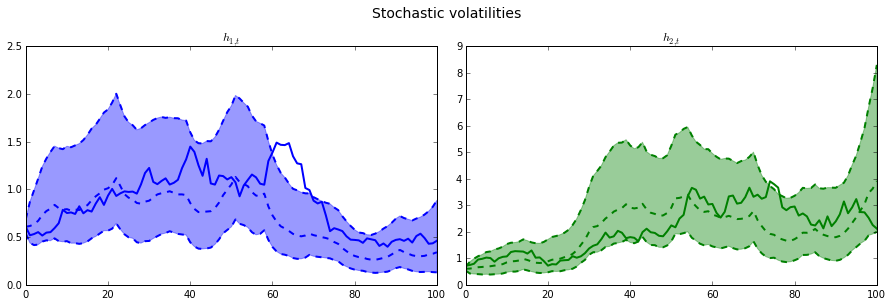

In [21]:
figsize(12.5,4)
fig3, bx = plt.subplots(1, 2)
plt.suptitle(r'Stochastic volatilities', y=1.05, fontsize=14)

bx[0].plot(np.exp(lnH_obs[0,:]), color='b', label = r"$h_{1,t}$", linewidth=2)
lnH1_10 = [np.percentile(np.exp(mcmc.trace('lnh_%d' % i)[:][:,0]),10) for i in range(T+1)]
lnH1_50 = [np.percentile(np.exp(mcmc.trace('lnh_%d' % i)[:][:,0]),50) for i in range(T+1)]
lnH1_90 = [np.percentile(np.exp(mcmc.trace('lnh_%d' % i)[:][:,0]),90) for i in range(T+1)]
bx[0].plot(lnH1_10, linewidth=2, linestyle='--', color='b')
bx[0].plot(lnH1_50, linewidth=2, linestyle='--', color='b')
bx[0].plot(lnH1_90, linewidth=2, linestyle='--', color='b')
bx[0].fill_between(range(T+1),lnH1_10, lnH1_90, color="b", alpha=0.4)
bx[0].set_title('$h_{1,t}$')

bx[1].plot(np.exp(lnH_obs[1,:]), color='g', label = r"$h_{2,t}$",linewidth=2)
lnH2_10 = [np.percentile(np.exp(mcmc.trace('lnh_%d' % i)[:][:,1]),10) for i in range(T+1)]
lnH2_50 = [np.percentile(np.exp(mcmc.trace('lnh_%d' % i)[:][:,1]),50) for i in range(T+1)]
lnH2_90 = [np.percentile(np.exp(mcmc.trace('lnh_%d' % i)[:][:,1]),90) for i in range(T+1)]
bx[1].plot(lnH2_10, linewidth=2, linestyle='--', color='g')
bx[1].plot(lnH2_50, linewidth=2, linestyle='--', color='g')
bx[1].plot(lnH2_90, linewidth=2, linestyle='--', color='g')
bx[1].fill_between(range(T+1),lnH2_10, lnH2_90, color="g", alpha=0.4)
bx[1].set_title('$h_{2,t}$')

plt.tight_layout()
plt.show()

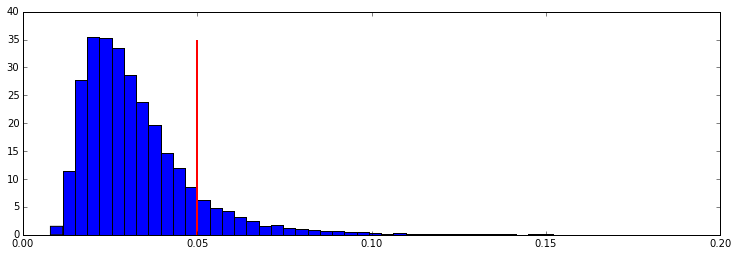

In [22]:
plt.hist([ np.trace(inv(mcmc.trace('Q_inv')[:][i])) for i in range(NI-NB)], bins=50, normed=True)
plt.vlines(np.trace(Q_bar_T), 0, 35, color='r', lw=2)

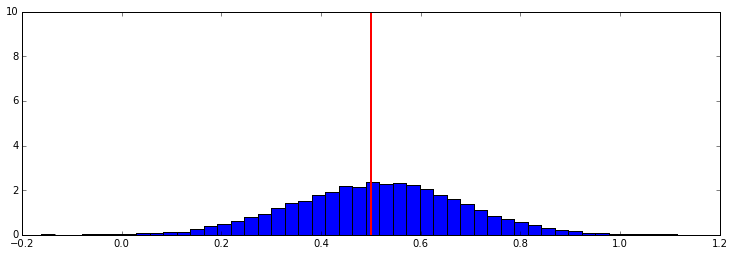

In [23]:
plt.hist(np.asarray([ mcmc.trace('betas')[:][i] for i in range(NI-NB)]), bins=50, normed=True)
plt.vlines(beta_T[0], 0, 10, color='r', lw=2)

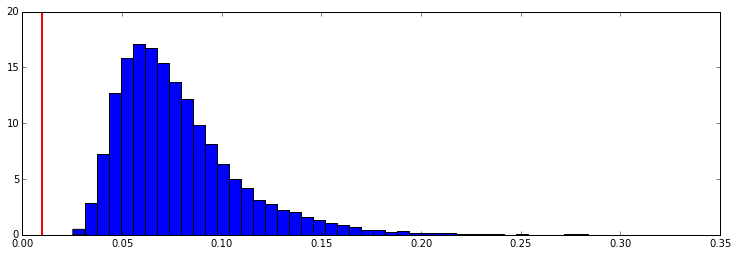

In [24]:
plt.hist(np.asarray([ mcmc.trace('sigma2_1')[:][i] for i in range(NI-NB)]), bins=50, normed=True)
plt.vlines(sigma_T[0], 0, 20, color='r', lw=2)

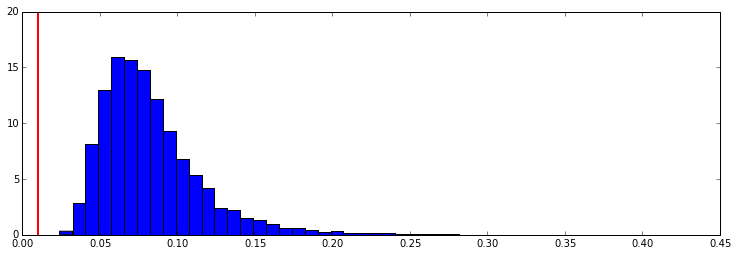

In [25]:
plt.hist(np.asarray([ mcmc.trace('sigma2_2')[:][i] for i in range(NI-NB)]), bins=50, normed=True)
plt.vlines(sigma_T[1], 0, 20, color='r', lw=2)

Plotting lnh_70_0
Plotting lnh_70_1


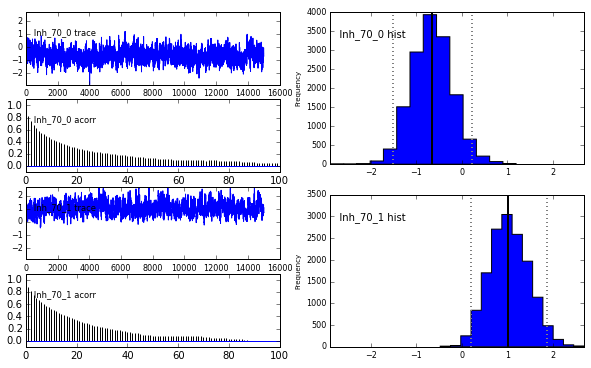

In [26]:
fancy_plot(LH[70])

Plotting Theta_70_0
Plotting Theta_70_1
Plotting Theta_70_2
Plotting Theta_70_3
Plotting Theta_70_4
Plotting Theta_70_5


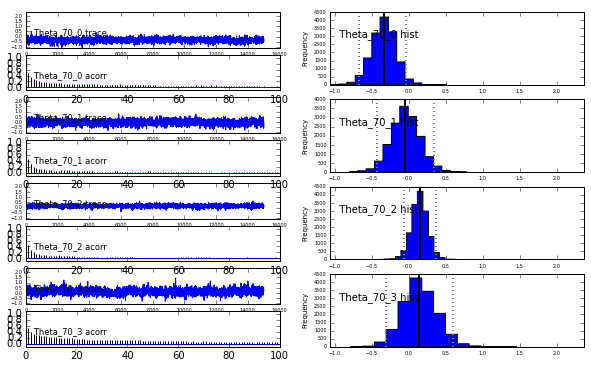

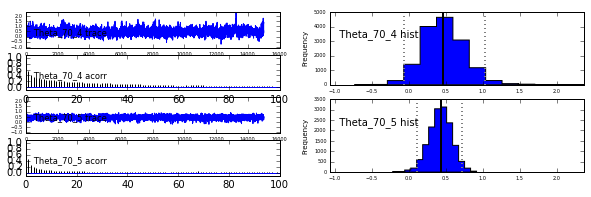

In [27]:
fancy_plot(Theta[70])

Plotting sigma2_1


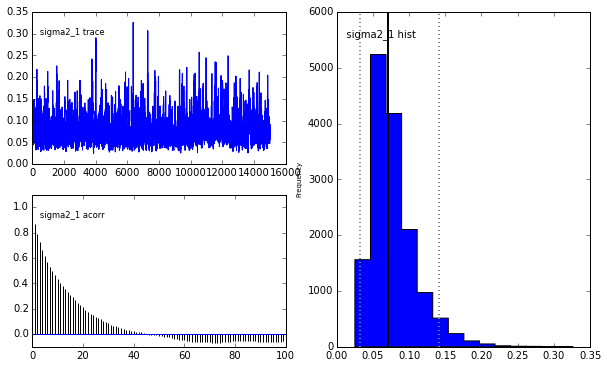

In [28]:
fancy_plot(Sigma2[0])

Plotting sigma2_2


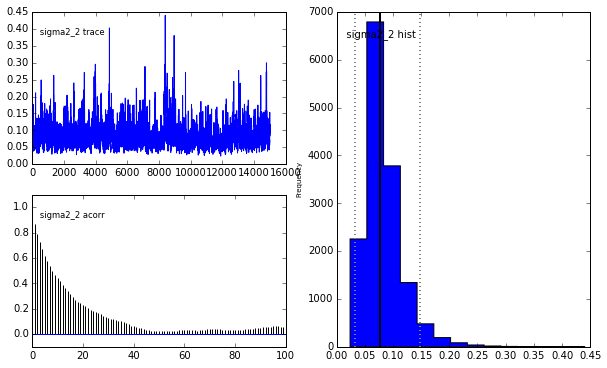

In [29]:
fancy_plot(Sigma2[1])

Plotting betas_0


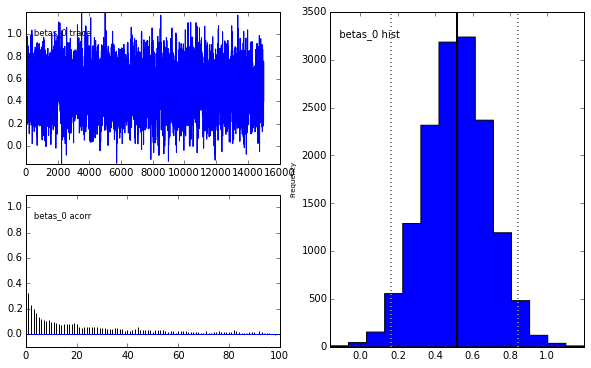

In [30]:
fancy_plot(Betas)